In [1]:
import networkx
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import momepy
import numpy as np
import pandas as pd
import shapely
import geopy
import geopandas
from road_system import *

# Step 1 Data Cleaning

In [30]:
#Import Raw Data, Retrieved from Tomtom Traffic Stats
filepath = "LBA3.geojson"
ba_grid = geopandas.read_file(filepath, rows = slice(1,100))
ba_grid.head()

,jobName,creationTime,segmentId,newSegmentId,speedLimit,frc,streetName,distance,segmentTimeResults,userPreference,dateRanges,timeSets,networkName,zoneId,probeSource,geometry
0,None,NaT,-10320002761861,-00004145-3100-0400-0000-00000001cbf8,35,6,Calle Viamonte,127.17,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...",None,None,None,None,None,None,"LINESTRING (-58.37820 -34.60006, -58.37682 -34..."
1,None,NaT,-10320002758024,-00004145-3100-0400-0000-00000001d6c4,35,6,Calle Maipú,128.05,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...",None,None,None,None,None,None,"LINESTRING (-58.37685 -34.59881, -58.37682 -34..."
2,None,NaT,-10320002729431,-00004145-3100-0400-0000-000000045e6b,35,6,Calle Viamonte,141.21,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...",None,None,None,None,None,None,"LINESTRING (-58.38119 -34.60023, -58.37966 -34..."
3,None,NaT,-10320002377592,-00004145-3100-0400-0000-000000048678,35,6,Calle Viamonte,134.69,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...",None,None,None,None,None,None,"LINESTRING (-58.37682 -34.59997, -58.37536 -34..."
4,None,NaT,-10320002377593,-00004145-3100-0400-0000-000000049200,35,6,Calle Maipú,126.86,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...",None,None,None,None,None,None,"LINESTRING (-58.37682 -34.59997, -58.37675 -34..."


In [3]:
#Clean Input Data: Expand Data Entry Dictoinary into Individual Entries
df =  ba_grid[["streetName","distance","geometry", "speedLimit"]]
df = df.join((ba_grid["segmentTimeResults"].map(lambda x : eval(x)[0])).apply(pd.Series)).drop(["timeSet", "dateRange"], axis = 1)

In [4]:
df.head()

,streetName,distance,geometry,speedLimit,harmonicAverageSpeed,medianSpeed,averageSpeed,standardDeviationSpeed,travelTimeStandardDeviation,sampleSize,averageTravelTime,medianTravelTime,travelTimeRatio,speedPercentiles
0,Calle Viamonte,127.17,"LINESTRING (-58.37820 -34.60006, -58.37682 -34...",35,11.09,15.25,15.63,8.26,28.73,1741,41.28,30.02,1.0,"[5, 6, 7, 7, 8, 9, 11, 12, 14, 15, 17, 18, 19,..."
1,Calle Maipú,128.05,"LINESTRING (-58.37685 -34.59881, -58.37682 -34...",35,9.77,11.12,12.75,6.94,27.04,972,47.16,41.46,1.0,"[5, 6, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, ..."
2,Calle Viamonte,141.21,"LINESTRING (-58.38119 -34.60023, -58.37966 -34...",35,13.56,17.37,19.17,9.96,29.49,2352,37.50,29.27,1.0,"[7, 8, 9, 10, 10, 11, 12, 14, 15, 17, 19, 21, ..."
3,Calle Viamonte,134.69,"LINESTRING (-58.37682 -34.59997, -58.37536 -34...",35,8.47,8.43,11.15,7.13,29.02,1421,57.25,57.52,1.0,"[5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 10, 11, 12, ..."
4,Calle Maipú,126.86,"LINESTRING (-58.37682 -34.59997, -58.37675 -34...",35,9.40,10.50,12.10,6.42,26.68,1047,48.58,43.49,1.0,"[5, 6, 7, 7, 8, 8, 9, 9, 10, 11, 11, 12, 13, 1..."


In [5]:
#Convert Geometry Objects into X and Y lines
x,y = [],[]
for line in df["geometry"]:
    for tuple in line.coords[0:2]:
        x.append(tuple[1])
        y.append(tuple[0])
#Set min x and y as origin of our map
origin_x = min(x)
origin_y = min(y)
#Convert from long-lat coordinate system into new coordinates
new_coords = []
for line in df["geometry"]:
    entry = []
    for tuple in line.coords[0:2]:
        entry.extend([tuple[0] - origin_y, tuple[1] - origin_x])
    new_coords.append(entry)
#Data-specific Cleaning -- Some entry had two line segments instead of 1, don't know why
start_y, start_x = (df["geometry"][6].coords.xy)[0][0] ,(df["geometry"][6].coords.xy)[1][0]
end_y, end_x = (df["geometry"][6].coords.xy)[0][3], (df["geometry"][6].coords.xy)[1][3]
new_coords[6]  = [start_y - origin_y, start_x - origin_x, end_y - origin_y, end_x - origin_x]
#Convert Angle Difference into Meters
test_frame = np.array(new_coords)*111139 #convert angle differences to meters 
#from https://sciencing.com/convert-distances-degrees-meters-7858322.html


#Finish Cleaning
cleaned_df = df.join(pd.DataFrame(test_frame, columns = ["start_x", "start_y", "end_x","end_y"]))
cleaned_df.head()

,streetName,distance,geometry,speedLimit,harmonicAverageSpeed,medianSpeed,averageSpeed,standardDeviationSpeed,travelTimeStandardDeviation,sampleSize,averageTravelTime,medianTravelTime,travelTimeRatio,speedPercentiles,start_x,start_y,end_x,end_y
0,Calle Viamonte,127.17,"LINESTRING (-58.37820 -34.60006, -58.37682 -34...",35,11.09,15.25,15.63,8.26,28.73,1741,41.28,30.02,1.0,"[5, 6, 7, 7, 8, 9, 11, 12, 14, 15, 17, 18, 19,...",332.30561,260.06526,485.67743,270.06777
1,Calle Maipú,128.05,"LINESTRING (-58.37685 -34.59881, -58.37682 -34...",35,9.77,11.12,12.75,6.94,27.04,972,47.16,41.46,1.0,"[5, 6, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, ...",482.34326,398.98901,485.67743,270.06777
2,Calle Viamonte,141.21,"LINESTRING (-58.38119 -34.60023, -58.37966 -34...",35,13.56,17.37,19.17,9.96,29.49,2352,37.50,29.27,1.0,"[7, 8, 9, 10, 10, 11, 12, 14, 15, 17, 19, 21, ...",0.00000,241.17163,170.04267,252.28553
3,Calle Viamonte,134.69,"LINESTRING (-58.37682 -34.59997, -58.37536 -34...",35,8.47,8.43,11.15,7.13,29.02,1421,57.25,57.52,1.0,"[5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 10, 11, 12, ...",485.67743,270.06777,647.94037,283.40445
4,Calle Maipú,126.86,"LINESTRING (-58.37682 -34.59997, -58.37675 -34...",35,9.40,10.50,12.10,6.42,26.68,1047,48.58,43.49,1.0,"[5, 6, 7, 7, 8, 8, 9, 9, 10, 11, 11, 12, 13, 1...",485.67743,270.06777,493.45716,143.36931


In [6]:
#Find the nodes of intersection, inflow and outflow types
starts = set(zip(cleaned_df.start_x, cleaned_df.start_y))
ends = set(zip(cleaned_df.end_x, cleaned_df.end_y))
intersection_nodes = list(starts.intersection(ends))
inflow_nodes = list(starts.difference(intersection_nodes))
outflow_nodes = list(ends.difference(intersection_nodes))


In [7]:
#Create List of Input Nodes
intersection_nodes_df = pd.DataFrame(intersection_nodes, columns = ["x","y"])
intersection_nodes_df["type"] = "intersection"

inflow_nodes_df = pd.DataFrame(inflow_nodes, columns = ["x","y"])
inflow_nodes_df["type"] = "inflow"

outflow_nodes_df = pd.DataFrame(outflow_nodes, columns = ["x","y"] )
outflow_nodes_df["type"] = "outflow"

nodes = pd.concat([inflow_nodes_df,intersection_nodes_df,outflow_nodes_df], ignore_index= True)
nodes["Node_ID"] = nodes.index
nodes.head()

,x,y,type,Node_ID
0,0.00000,241.17163,inflow,0
1,342.30812,0.00000,inflow,1
2,650.16315,153.37182,inflow,2
3,482.34326,398.98901,inflow,3
4,493.45716,143.36931,intersection,4


In [8]:
#Assign ID to edges and preview pattern
cleaned_df["avg_x"] = (cleaned_df["start_x"] + cleaned_df["end_x"]) / 2
cleaned_df["avg_y"] = (cleaned_df["start_y"] + cleaned_df["end_y"]) / 2
edges = cleaned_df.sort_values(by = "avg_y", ascending= False).sort_values(by = "avg_x").reset_index(drop = True)
edges.insert(loc = 0, column = "Edge_ID", value = df.index)
edges.drop(["avg_x", "avg_y", "geometry"], axis = 1, inplace = True)
edges.head()

,Edge_ID,streetName,distance,speedLimit,harmonicAverageSpeed,medianSpeed,averageSpeed,standardDeviationSpeed,travelTimeStandardDeviation,sampleSize,averageTravelTime,medianTravelTime,travelTimeRatio,speedPercentiles,start_x,start_y,end_x,end_y
0,0,Calle Viamonte,141.21,35,13.56,17.37,19.17,9.96,29.49,2352,37.50,29.27,1.0,"[7, 8, 9, 10, 10, 11, 12, 14, 15, 17, 19, 21, ...",0.00000,241.17163,170.04267,252.28553
1,1,Calle Tucumán,136.98,35,7.90,7.56,11.11,8.17,31.41,1677,62.45,65.23,1.0,"[5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9, 10, 11, 1...",175.59962,126.69846,10.00251,114.47317
2,2,Calle Viamonte,134.00,35,8.53,8.56,11.97,7.90,34.38,1948,56.54,56.36,1.0,"[5, 6, 6, 7, 7, 7, 7, 8, 8, 9, 9, 10, 10, 12, ...",170.04267,252.28553,332.30561,260.06526
3,3,Calle Tucumán,132.62,35,9.94,10.68,13.46,7.92,32.25,1397,48.02,44.70,1.0,"[5, 7, 7, 8, 8, 9, 9, 10, 10, 11, 12, 13, 14, ...",336.75117,134.47819,175.59962,126.69846
4,4,Calle Esmeralda,128.64,35,10.15,12.25,14.14,7.88,35.02,760,45.64,37.80,1.0,"[5, 6, 6, 7, 7, 8, 9, 10, 11, 12, 14, 16, 17, ...",332.30561,260.06526,321.19171,388.98650


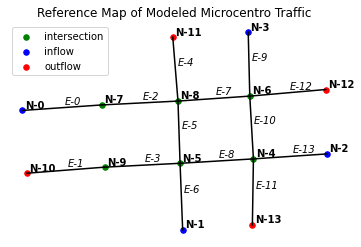

In [9]:
#Preview Graph system, and Label Edges and Nodes for referencing
import matplotlib.pyplot as plt
for i,row in enumerate(edges.loc[:,["start_x", "start_y", "end_x", "end_y"]].iterrows()):
    row = row[1]
    plt.plot([row[0],row[2]],[row[1],row[3]], color = "black")
    plt.text((row[0]+row[2])/2 + 5,(row[1]+row[3])/2 + 8 , f"E-{i}", fontstyle = "italic")
plt.scatter("x","y", data = intersection_nodes_df, color = "green", s = 30, label = "intersection")
plt.scatter("x","y", data = inflow_nodes_df, color = "blue", s = 30, label = "inflow")
plt.scatter("x","y", data = outflow_nodes_df, color = "red", s = 30, label = "outflow")
for row in nodes.iterrows():
    row = row[1]
    plt.text(row[0]+5, row[1]+5, f"N-{row[3]}", fontweight = "bold")
plt.title("Reference Map of Modeled Microcentro Traffic")
plt.legend()
plt.tick_params(axis='both', which='both', reset = True,  bottom='off', top='off', labelbottom='off', right='off',
                              left='off',
                              labelleft='off')
plt.axis("off")
plt.show()

In [10]:
#Add to each edge the starting and ending node ID to be networkX compatible
edges = pd.merge(edges, nodes.drop("type", axis = 1), how = "left",
         left_on=["start_x", "start_y"],
         right_on= ["x","y"])
edges.drop(["x","y"], axis = 1, inplace = True)
edges.rename(columns = {"Node_ID":"In"}, inplace = True)
edges = pd.merge(edges, nodes.drop("type", axis = 1), how = "left",
         left_on=["end_x", "end_y"],
         right_on= ["x","y"])
edges.drop(["x","y"], axis = 1, inplace = True)
edges.rename(columns = {"Node_ID":"Out"}, inplace = True)
edges.head()


,Edge_ID,streetName,distance,speedLimit,harmonicAverageSpeed,medianSpeed,averageSpeed,standardDeviationSpeed,travelTimeStandardDeviation,sampleSize,averageTravelTime,medianTravelTime,travelTimeRatio,speedPercentiles,start_x,start_y,end_x,end_y,In,Out
0,0,Calle Viamonte,141.21,35,13.56,17.37,19.17,9.96,29.49,2352,37.50,29.27,1.0,"[7, 8, 9, 10, 10, 11, 12, 14, 15, 17, 19, 21, ...",0.00000,241.17163,170.04267,252.28553,0,7
1,1,Calle Tucumán,136.98,35,7.90,7.56,11.11,8.17,31.41,1677,62.45,65.23,1.0,"[5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9, 10, 11, 1...",175.59962,126.69846,10.00251,114.47317,9,10
2,2,Calle Viamonte,134.00,35,8.53,8.56,11.97,7.90,34.38,1948,56.54,56.36,1.0,"[5, 6, 6, 7, 7, 7, 7, 8, 8, 9, 9, 10, 10, 12, ...",170.04267,252.28553,332.30561,260.06526,7,8
3,3,Calle Tucumán,132.62,35,9.94,10.68,13.46,7.92,32.25,1397,48.02,44.70,1.0,"[5, 7, 7, 8, 8, 9, 9, 10, 10, 11, 12, 13, 14, ...",336.75117,134.47819,175.59962,126.69846,5,9
4,4,Calle Esmeralda,128.64,35,10.15,12.25,14.14,7.88,35.02,760,45.64,37.80,1.0,"[5, 6, 6, 7, 7, 8, 9, 10, 11, 12, 14, 16, 17, ...",332.30561,260.06526,321.19171,388.98650,8,11


In [11]:
import networkx as nx
G = nx.from_pandas_edgelist(edges, source = "In", target= "Out",
                        edge_attr = True, create_using= nx.DiGraph )

In [12]:
for i in G.nodes:
    G.nodes[i]["Node_ID"] = nodes['Node_ID'][i]
    G.nodes[i]["type"] = nodes["type"][i]
    G.nodes[i]["x_pos"]= nodes["x"][i]
    G.nodes[i]["y_pos"]= nodes["y"][i]

In [13]:
from tqdm import tqdm
def make_animation(sim, total_frames, steps_per_frame=1, interval=100, title = ''):
    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.update()
        progress_bar.update(1)
        return [sim.draw(title = title)]

    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output


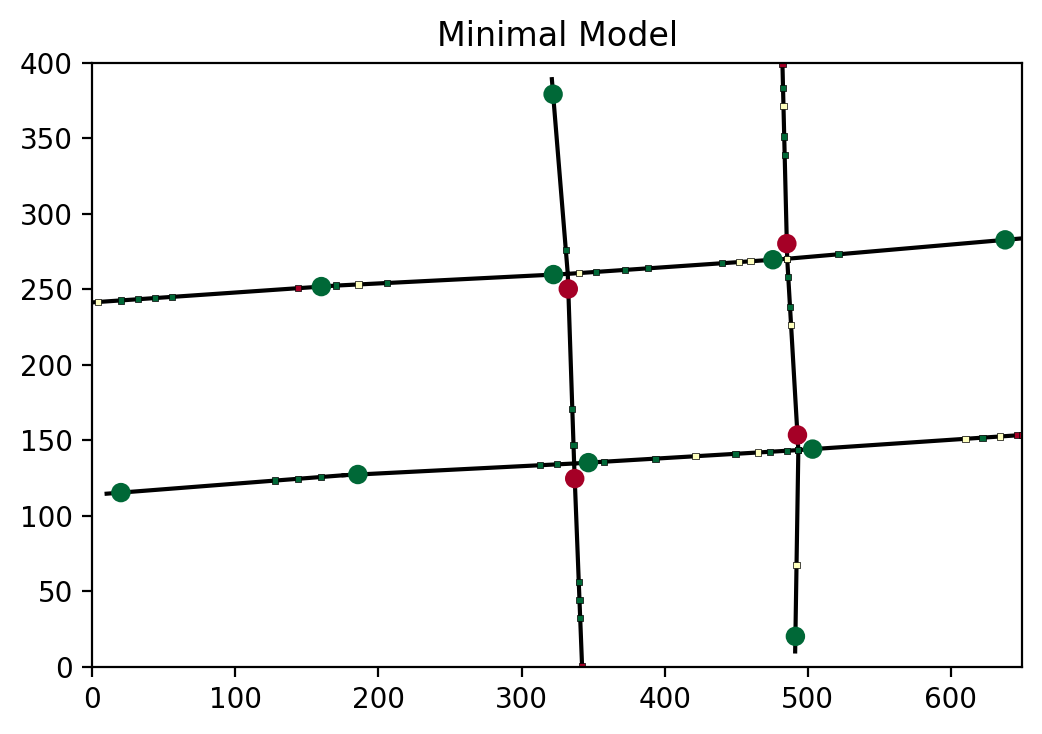

In [21]:
sim = TrafficSystem()
out = sim.build_network(edges, nodes, dpi = 200)
for __ in range(100):
    sim.update()
sim.draw("Minimal Model")

In [20]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as anim
import numpy as np
from IPython.display import HTML
from tqdm import tqdm
make_animation(sim, total_frames=500, steps_per_frame=2, title = "Minimal Model")

100%|█████████████████████████████████████████| 500/500 [00:22<00:00, 22.13it/s]


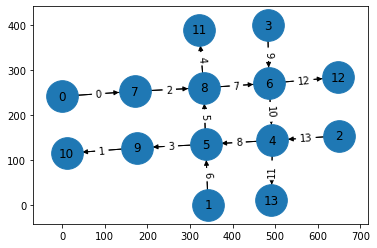

In [16]:
pos = {}
for node, data in sim.traffic_grid.nodes(data = True):
    pos[node] = [data["x_pos"], data["y_pos"]]
fig, ax = plt.subplots()
G = sim.traffic_grid
nx.draw(G, pos=pos, node_color='k', ax=ax)
nx.draw(G, pos=pos, node_size=1000, ax=ax)  # draw nodes and edges
nx.draw_networkx_labels(G, pos=pos)  # draw node labels/names
# draw edge weights
labels = nx.get_edge_attributes(G, 'Edge_ID')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
plt.axis("on")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

## Further Sanity Checks
The number of cars in the road system seems correct, and we are not having cars lost somewhere

In [27]:
#The number of cars on each road segment, 
count = 0
for road in sorted(sim.roads, key = lambda x: x.ID):
    count += len(road.vehicles)
    print(f"Vehicles in Road {road.ID}:",len(road.vehicles))
print(f"Total number of cars in road {sum([1 for road in sim.roads for vehicle in road.vehicles if abs(vehicle.rel_pos) < road.length])}")

Vehicles in Road 0: 7
Vehicles in Road 1: 3
Vehicles in Road 2: 3
Vehicles in Road 3: 2
Vehicles in Road 4: 1
Vehicles in Road 5: 2
Vehicles in Road 6: 4
Vehicles in Road 7: 7
Vehicles in Road 8: 8
Vehicles in Road 9: 5
Vehicles in Road 10: 6
Vehicles in Road 11: 3
Vehicles in Road 12: 2
Vehicles in Road 13: 5
Total number of cars in road 58


# Data Cleaning Completed, Save Cleaned File

In [19]:
import pickle
with open("nodes", "wb") as fp:   #Pickling
    pickle.dump(nodes, fp)
with open("edges", "wb") as fp:   #Pickling
    pickle.dump(edges, fp)
with open("traffic_network", "wb") as fp:
    pickle.dump(G, fp)